## Transformer

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

未来方便运行，我们只采用了一句话。

In [13]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

S: symbol that shows starting of decoding input

E: symbol that shows starting of decoding output

P: symbol that will fill in blank sequence if current batch data size is shorter than time step


定义我们的字典映射，确定句子的长度。

In [14]:
# Transformer parameters
# Padding should be zero
src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
src_vocab_size = len(src_vocab)
print(src_vocab_size)
tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i:w for w, i in tgt_vocab.items()}
tgt_vocab_size = len(tgt_vocab)
print(number_dict)

5
{0: 'P', 1: 'i', 2: 'want', 3: 'a', 4: 'beer', 5: 'S', 6: 'E'}


这里定义了几个比较重要的参数：
- 词嵌入的维度：512
- 全连接前向网络的输出维度：2048。（在进行了Attention操作之后，encoder和decoder中的每一层都包含了一个全连接前向网络）
- K、Q、V的维度
- 调用多少个Encoderlayer和Decoderlayer。论文中使用了6个。
- Multi-head attention的数目。论文中为8个

In [15]:
d_model = 512 # Embedding size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64 # dimension of K, Q, V
n_layers = 6 # number of encoder and decoder layers
n_heads = 8 # number of heads in Multi-Head Attention

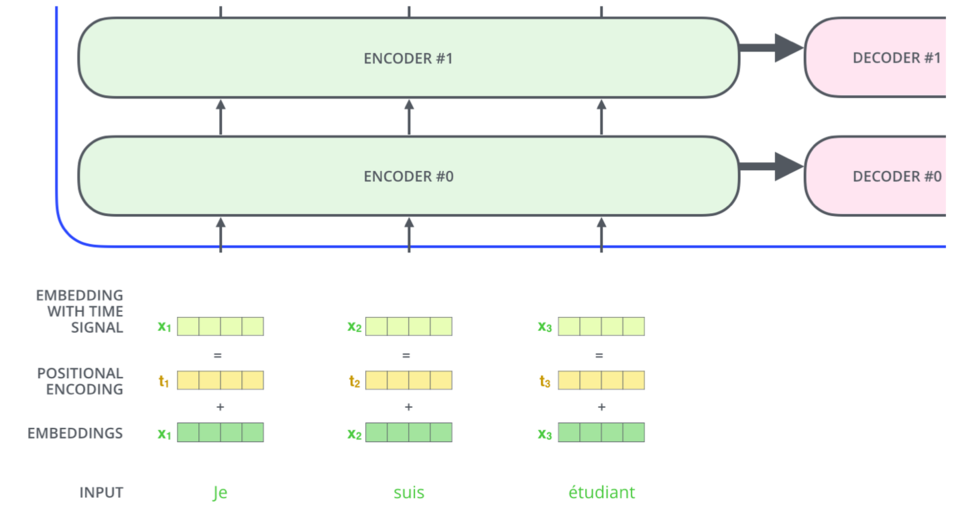

In [16]:
def make_batch(sentences):
    input_batch = [[src_vocab[w] for w in sentences[0].split(" ")]]
    print(input_batch)
    output_batch = [[tgt_vocab[w] for w in sentences[1].split(" ")]]
    print(output_batch)
    target_batch = [[tgt_vocab[w] for w in sentences[2].split(" ")]]
    print(target_batch)
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

In [17]:
make_batch(sentences)

[[1, 2, 3, 4, 0]]
[[5, 1, 2, 3, 4]]
[[1, 2, 3, 4, 6]]


(tensor([[1, 2, 3, 4, 0]]),
 tensor([[5, 1, 2, 3, 4]]),
 tensor([[1, 2, 3, 4, 6]]))

In [18]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

3.mask

mask的作用主要是为了在计算Attention的时候，让模型看不到未来的信息。

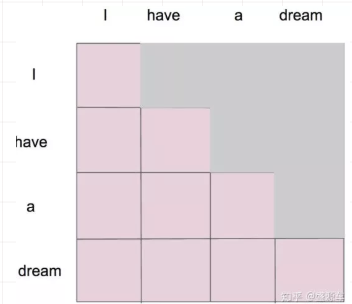

例如，对于I，只有其与自身的Attention。对于第二个单词have，有其与I和自身的两个Attention。




pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
eq函数是留下seq_k等于0的坐标，seq_k是enc_inputs


In [19]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    return pad_attn_mask.expand([batch_size, len_q, len_k])

In [20]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

![img](https://pic4.zhimg.com/80/v2-15f871fac203f20a87d7ab067549833b_720w.jpg)



图1 Attention机制的本质思想

我们可以这样来看待Attention机制（参考图1）： 将Source中的构成元素想象成是由一系列的<Key,Value>数据对构成，此时给定Target中的某个元素Query，通过计算Query和各个Key的相似性或者相关性，得到每个Key对应Value的权重系数，然后对Value进行加权求和，即得到了最终的Attention数值。所以本质上Attention机制是对Source中元素的Value值进行加权求和，而Query和Key用来计算对应Value的权重系数。即可以将其本质思想改写为如下公式：

![img](https://pic4.zhimg.com/80/v2-56af9b2c9d8e39e632cbd4e444870927_720w.jpg)

上文所举的机器翻译的例子里，因为在计算Attention的过程中，Source中的Key和Value合二为一，指向的是同一个东西，也即输入句子中每个单词对应的语义编码，所以可能不容易看出这种能够体现本质思想的结构。
当然，从概念上理解，把Attention仍然理解为从大量信息中有选择地筛选出少量重要信息并聚焦到这些重要信息上，忽略大多不重要的信息，这种思路仍然成立。聚焦的过程体现在权重系数的计算上，权重越大越聚焦于其对应的Value值上，即权重代表了信息的重要性，而Value是其对应的信息。
**从图1可以引出另外一种理解，也可以将Attention机制看作一种软寻址（Soft Addressing）:**
**Source可以看作存储器内存储的内容，元素由地址Key和值Value组成，当前有个Key=Query的查询，目的是取出存储器中对应的Value值，即Attention数值。通过Query和存储器内元素Key的地址进行相似性比较来寻址，之所以说是软寻址，指的不像一般寻址只从存储内容里面找出一条内容，而是可能从每个Key地址都会取出内容，取出内容的重要性根据Query和Key的相似性来决定，之后对Value进行加权求和，这样就可以取出最终的Value值，也即Attention值。所以不少研究人员将Attention机制看作软寻址的一种特例，这也是非常有道理的。**
**至于Attention机制的具体计算过程，如果对目前大多数方法进行抽象的话，可以将其归纳为两个过程：第一个过程是根据Query和Key计算权重系数，第二个过程根据权重系数对Value进行加权求和。而第一个过程又可以细分为两个阶段：第一个阶段根据Query和Key计算两者的相似性或者相关性；第二个阶段对第一阶段的原始分值进行归一化处理；这样，可以将Attention的计算过程抽象为三个阶段。**





**![img](https://pic3.zhimg.com/80/v2-ae1625293164d0ec41cfc0be7487b0ba_720w.jpg)**



In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]